# **TP - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

# **Problema 2  - Circuito**

$\quad$Considere-se um circuito booleano $\,\mathcal{C}\,$ com $\,n\,$ “wires” de “input” e um único “wire” de output.
    - O circuito é descrito num bi-grafo com uma classe de nodos representando “gates” e a segunda classe representando “wires” . 
    - Cada nodo contém um campo val cujo conteúdo descreve a semântica desse nodo; para os “wires” o campo val  contém uma variável SCIP; para as “gates” o campo val  contém uma marca bo conjunto and, or,  xor e not,   que indica o tipo de “gate”. 
    - Com exceção de not , que é um operador unário, todas as restantes “gates” têm um número arbitrário de “inputs” e um único “output”.
    - No grafo os arcos com origem numa determinada “gate”  têm destino nos “wires” que são “input” dessa “gate”. Cada “wire” que não é “input” é origem de um único arco que tem como destino a “gate” do qual esse “wire” é “output”.
    - A semântica das várias “gates” é expressa em relações na Aritmética Linear Inteira, tal como está descrita em +Capítulo 2: Programação com Restrições (#LIA)

$\quad$a. Escreva um programa que, a partir do número $\,n\,$ de “inputs”  e de um parâmetro positivo $\,\gamma\ll 1\,$ como argumentos,  gere aleatoriamente circuitos com “gates” or, and e not  em que o número de and's é  $\,\gamma\ast\,$ (número total de nodos).<br>

$\quad$b. Escreva um programa Python que leia um circuito arbitrário descrito pelo bi-grafo anterior e formule as restrições (em Programação Inteira) que descrevem as várias “gates” do circuito.<br>

$\quad$c. Usando os dois programas anteriores e o sistema SCIP:<br> 
$\qquad$c1. Escreva um programa que determine um vetor de “inputs”   $\,x\in\{0,1\}^n\,$ aceite pelo circuito (i.e. o respetivo output é $1$).<br>
$\qquad$c2. Determine o vetor $x'\neq x$ , também aceite pelo circuito, que está mais próximo de $x$.

In [1]:
import networkx as nx
from ortools.linear_solver import pywraplp
import random

## Função que gera circuito

$\quad$Pare gerar o circuito, em primeiro lugar foram calculados o número de gates "XOR", "OR", e "NOT" de forma aleatoria e o número de gates "AND" com base no do valor de $\gamma$ . De seguida foi criado um bi-grafo ao qual adicionamos os nodos  que representam os "inputs" e as "gates" assim como os "wires" que vão representar o "output" de cada gate. Por cada "gate" foi adicionado um "wire" e uma aresta dessa gate para o respetivo "wire". Todos o nodos foram etiquetados de forma a identificar qual a sua função no circuito. As etiquetas utilizadas foram:<br>
$\quad$- "INPUT",<br> 
$\quad$- "AND",<br>
$\quad$- "NOT",<br>
$\quad$- "OR",<br>
$\quad$- "XOR",<br>
$\quad$- "WIRE",<br>
$\quad$- "OUTPUT";<br>
$\quad$As "gates" tambem foram etiquetadas com o nínel a que pertenciam no circuito assim como qual o nodo ("wire") de output, de forma a auxiliar na construção do circuito.<br>
Para ligar as varias gates foi feito um genero de travessia, usando para tal uma "orla" cujo primeiro elemento é a gate que está ligada ao "wire" identificado como "output" do circuito. Após selecionar e remover o nodo mais antigo da "orla" havia duas opções:<br>
$\quad$ - Se a gate **g1** for um "NOT" é escolhida de forma aleatoria uma gate **g2** com um nivel superior ao de **g1** sendo depois criada uma aresta (g2,g1).<br>
$\quad$ - Se a gate **$g$** não for um "NOT" são escolhidas de forma aleatoria varias gates **g2..gn** com nivel superior ao de **g1** sendo depois criadas as arestas (g2,g1)...(gn,g1).<br>
$\quad$Todas as gates selecionadas de forma aleatoria no passo anterior são adicionadas à "orla". O processo termina quando a "orla" fica vazia. Como no processo anterior podem resultar "gates" que nao se encontram ligadas ao circuito, são realiazos alguns ciclos de forma a ligar todas a "gates de forma a que o circuito faça "sentido".
$\quad$Por fim, são ligados os nodos de "INPUT" ao circuito de forma aleatória às gates cujo grau de incidencia é 0 no caso de gates "NOT" ou $<2$ no caso das restantes "gates".




In [2]:
def circuit_generator(I,Alpha):
    num_xors = random.randint(0,I)
    num_nots = random.randint(0,I)
    num_ors = random.randint(0,I)
    num_ands = int((num_xors + num_nots + num_ors) * Alpha / (1-Alpha))
    G = nx.DiGraph()
    total = 0
    
    #adicionar e etiquetar aos varios nodos do grafo
    
    for n in range(I):
        G.add_node(n,type="INPUT",val=None,color=1)
    
    total += I
    
    for n in range(num_xors):
        G.add_node(total+n,type="XOR",color=2)
    
    total += num_xors
    
    for n in range(num_nots):
        G.add_node(total+n,type="NOT",color=3)
    
    total += num_nots
    
    
    for n in range(num_ors):
        G.add_node(total+n,type="OR",color=4)
    
    total += num_ors
    
    for n in range(num_ands):
        G.add_node(total+n,type="AND",color=5)
    
    total+= num_ands
    
    num_gates = total - I
    
    for n in range(num_gates):
        G.add_node(total+n,type="WIRE",val=None,color=6)
    
    gates = [n for n in G.nodes() if G.nodes[n]['type'] != 'INPUT' and G.nodes[n]['type'] != 'WIRE']
    wires = [n for n in G.nodes() if G.nodes[n]['type'] == 'WIRE']
    random.shuffle(gates)
    gates_info = {}
    
    # ligar cada gate ao seu wire de output 
    
    for edge in zip(gates,wires):
        G.add_edge(*edge)
        gates_info[edge[0]] = {'type':G.nodes[edge[0]]['type'] ,'output':edge[1],'level':float('inf')}
    
    output = random.choice(gates)
    G.nodes[gates_info[output]['output']]['type'] = 'OUTPUT'
    gates_info[output]['level'] = 1
    
    #criar o circuito ligando as varias gates
    
    orla = [output]
    while orla:
        x = orla.pop(0)
        candidates = [g for g in gates_info if gates_info[g]['level'] > gates_info[x]['level']]
        if candidates:
            random.shuffle(candidates)
            if gates_info[x]['type'] == 'NOT':
                selected = candidates.pop(0)
                gates_info[selected]['level'] = gates_info[x]['level'] +1 
                G.add_edge(gates_info[selected]['output'],x)
                orla.append(selected)
            elif len(candidates)>1:
                for i in range(random.randint(2,len(candidates))):
                    selected = candidates.pop(0)
                    gates_info[selected]['level'] = gates_info[x]['level'] +1 
                    G.add_edge(gates_info[selected]['output'],x)
                    orla.append(selected)

            
    # ligar gates que não se encontram ligadas ao circuito, ou seja, o grau de saida do nodo de output é 0
    
    unconected = [n for n in gates if G.out_degree[gates_info[n]['output']] == 0 and G.nodes[gates_info[n]['output']]['type']!= 'OUTPUT']
    for x in unconected:
        candidates = [n for n in gates if n not in unconected and G.nodes[n]['type'] != 'NOT']
        selected = random.choice(candidates)
        G.add_edge(gates_info[x]['output'],selected)
    
    # ligar gates cujo grau de incidencia é 0 aos nodos de input do circuito
    
    unconected = [n for n in gates if G.in_degree[n] == 0]
    
    for x in unconected:
        candidates = [i for i in G.nodes() if G.nodes[i]['type'] == 'INPUT']
        random.shuffle(candidates)
        if gates_info[x]['type'] == 'NOT':
            selected = candidates.pop(0)
            G.add_edge(selected,x)
        else:
            for i in range(random.randint(1,len(candidates))):
                selected = candidates.pop(0)
                G.add_edge(selected,x)
                
    # ligar gates NOT, XOR, AND cujo grau de incidenci é 1 aos nodos de input do circuito
    
    unconected = [n for n in gates if G.in_degree[n] == 1 and (G.nodes[n]['type'] == 'OR' or G.nodes[n]['type'] == 'XOR' or G.nodes[n]['type'] == 'AND')]
    for x in unconected:   
        candidates = [i for i in G.nodes() if G.nodes[i]['type'] == 'INPUT' and (i,x) not in G.edges()]
        selected = random.choice(candidates)
        G.add_edge(selected,x)
        
    # ligar nodos de input do circuito que ainde encontram desconectados a gates com aridade superior a 1
    
    unconected = [n for n in G if G.nodes[n]['type'] == 'INPUT' and G.out_degree(n) == 0]
    for x in unconected:
        candidates = [i for i in gates if G.nodes[i]['type'] != 'NOT']
        selected = random.choice(candidates)
        G.add_edge(x,selected)
    
    
    
    
      
        
    return G
    
    

0 INPUT
1 INPUT
2 XOR
3 OR
4 OR
5 OUTPUT
6 WIRE
7 WIRE


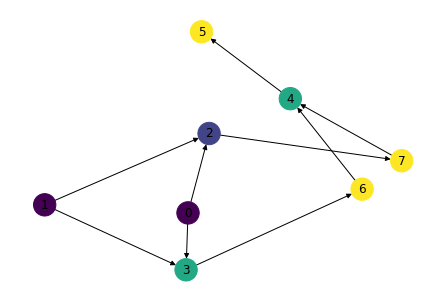

In [97]:
G = circuit_generator(2,0.2)
nx.draw(G, with_labels = True, node_size=500, node_color=[G.nodes[n]['color'] for n in G])
for g in G:
    print(g,G.nodes[g]['type'])

## Função que formula as restriçoes que descrevem as "gates" do circuito

$\quad$ Para formular as restrições temos que criar um Solver **solver** e um dicionario **X** onde vão ser guardadas as  variaveis SCIP, de tipo binario, correspondentes aos nodos "INPUT", "WIRE" e "OUTPUT" do circuito. No caso dos "XORs" será também criada uma variavel **T** do tipo inteiro. <br>
$\quad$ Para adicionar as restriçoes em primeiro lugar envertemos o circuito. De seguida iteramos por cada um dos nodos pertencentes ao tipo "WIRE" e "OUTPUT". Por cada nodo **n** da lista anterior, indentificamos qual o nodo **f** ao qual **n** se encontra ligado, o que no circuito não invertido é o "pai", ou seja, a "gate" da qual é **n**"output" e também recolhemos a lista **L** de todos os nodos aos quais **f** se encontra ligado, o que no circuito não invertido são os nodos de "input" dessa "gate. De seguida procedemos à formulação das restriçoes que vão depender do tipo de "gate" ao qual **f** pertence.<br>
$\quad$ Se **f** for do tipo "AND":<br>
$\qquad$ $\forall i \in L ,\ i \ge X[n] \quad ∧\quad \sum i \le X[n] -1 + len(L)$<br>
$\quad$ Se **f** for do tipo "NOT":<br>
$\qquad$ $X[n] == 1 - L[0]$<br>
$\quad$ Se **f** for do tipo "OR":<br>
$\qquad$ $\forall i \in L ,\ i \le X[n] \quad ∧\quad \sum i \ge X[n]$<br>
$\quad$ Se **f** for do tipo "XOR":<br>
$\qquad$ $X[n] == \sum_{i \in L} i - 2 \times T \quad ∧\quad  0 \le T \le +\infty $<br>
$\quad$ A função retorna o Solver e o dicionario X onde estão armazenadas as variaveis.


In [57]:
def add_restrictions(G):
    G = G.reverse()
    solver = pywraplp.Solver.CreateSolver('SCIP')
    variables = [n for n in G.nodes() if G.nodes[n]['type']=='INPUT' or G.nodes[n]['type']=='WIRE' or G.nodes[n]['type']=='OUTPUT']
    X = {}
    for n in variables:
        X[n] = solver.BoolVar(str(n))
    wires = [n for n in G if G.nodes[n]['type']=='WIRE' or G.nodes[n]['type']=='OUTPUT']
    for n in wires:
        father = list(G.neighbors(n)).pop()
        father_input = list(G.neighbors(father))
        if G.nodes[father]['type'] == "OR":
            solver.Add(sum([X[i] for i in father_input]) >= X[n])
            for i in father_input:
                solver.Add(X[n] >= X[i])
        elif G.nodes[father]['type'] == "AND":
            solver.Add(sum([X[i] for i in father_input]) <= X[n] + len(father_input) -1)
            for i in father_input:
                solver.Add(X[n] <= X[i])
        elif G.nodes[father]['type'] == "NOT":
            solver.Add(X[n] == 1 - X[father_input[0]])
        elif G.nodes[father]['type'] == "XOR":
            T = solver.IntVar(0,solver.infinity(),"XOR"+str(father))
            solver.Add(X[n] == sum([X[i] for i in father_input]) - 2*T)
    return solver, X
        
            
            
        
    

## Função que calcula vetor de input $x$ aceite peloo circuito

$\quad$ Para calcular o temos que adicionar mais duas restrições ao solver. Seja **I** a lista dos nodos "INPUT" do circuito e **o** o nodo "OUTPUT" do circuito, então:<br>
$\quad$ Minimizamos $\sum_{i \in I} i$.<br>
$\quad$ $X[o] == 1$.


In [81]:
def calculate_input(G):
    solver,X = add_restrictions(G)
    output = [n for n in G if G.nodes[n]['type'] == 'OUTPUT'].pop()
    inputs = [n for n in G if G.nodes[n]['type'] == 'INPUT']
    solver.Add(X[output] == 1)
    solver.Minimize(sum([X[n] for n in inputs]))
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        result = [round(X[i].solution_value()) for i in inputs]
        return result
    else:
        print("Sem Solução")
        return None
    
    

In [98]:
S = calculate_input(G)
print(S)

[0, 1]


## Função que calcula o vetor de input $x'\neq x$ aceite pelo circuito e mais proximo de $x$

$\quad$ Esta função para alem do circuito recebe o vetor de input $x$ aceite pelo circuito. Para calcular o vetor $x' \neq x$ mais próximo de $x$ que é aceite pelo circuito, temos que criar um dicionario ***E*** que vai armazenar variaveis binarias. O número de elementos de **E** é igual ao comprimento do vetor $x$. Também serão ultilizadas variaveis auxiliares do tipo inteiro às quais daremos o nome de **T**. Por uma questão de facilitação da leitura chamaremos de **A** ao vetor de inputs $x$ aceite pelo circuito e **N** o seu comprimento. Seja **I** a lista dos nodos "INPUT" do circuito, então:<br>
$\quad$ $\forall_{n \ \in \ [1..N]} \ X[I[n]] == E[n] + A[n] - 2 \times T \quad ∧\quad  0 \le T \le +\infty $<br>
$\quad$ $\sum_{e \ \in \ E} e \ge 1$<br>
$\quad$ Minimizamos $\sum_{e \ \in \ E} e$.<br>



In [3]:
def next_solution(G,S):
    solver,X = add_restrictions(G)
    E = {}
    output = [n for n in G if G.nodes[n]['type'] == 'OUTPUT'].pop()
    inputs = [n for n in G if G.nodes[n]['type'] == 'INPUT']
    solver.Add(X[output] == 1)
    solver.Minimize(sum([X[n] for n in inputs]))
    for i in range(len(inputs)):
        E[i] = solver.BoolVar("e"+str(i))
        T = solver.IntVar(0,solver.infinity(),"T"+str(i))
        solver.Add(E[i] + S[i] == X[inputs[i]] + 2*T )
    solver.Add(sum([E[n] for n in E]) >=1)
    solver.Minimize(sum([E[n] for n in E]))
    
    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        result = [round(X[i].solution_value()) for i in inputs]
        return result
    else:
        print("Sem Solução")
        return None
    

In [100]:
next_solution(G,S)

[1, 1]